# ER / NR discrimination test

In [ ]:
colab = False

if colab:
    # Install TF2 and TFP w GPU support (change runtime to GPU to test)
    !pip install -U tensorflow-gpu==2.0.0
    !pip install -U tensorflow_probability==0.8.0
    
    # Probably git clone missing here
    %cd flamedisx
    !git checkout master
    !git pull origin master
    !python setup.py develop
    %cd ..

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from multihist import Hist1d, Histdd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, interpolate

import flamedisx
import flamedisx as fd
from flamedisx.x1t_sr0 import SR0WIMPSource, SR0ERSource, SR0NRSource

tf.__version__, tfp.__version__, tf.test.is_gpu_available(), tf.executing_eagerly()

## Initialization

In [6]:
class LowMassWIMPSource(SR0WIMPSource):
    mw = 30  # GeV
    
class LowEnergyERSource(SR0ERSource):
    def _single_spectrum(self):
        """Return (energies in keV, rate at these energies),
        """
        return (tf.dtypes.cast(
                    tf.linspace(0., 5., 1000),
                    dtype=fd.float_type()),
                tf.ones(1000, dtype=fd.float_type()))
    
def annotate_cs(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])

In [7]:
dsets = dict(
    er=dict(source_class=LowEnergyERSource),
    nr=dict(source_class=LowMassWIMPSource))

for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](batch_size=200, max_sigma=6)

## Compute rate histograms

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


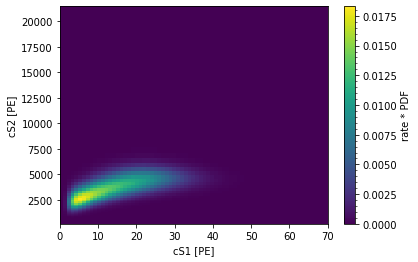

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.16it/s]


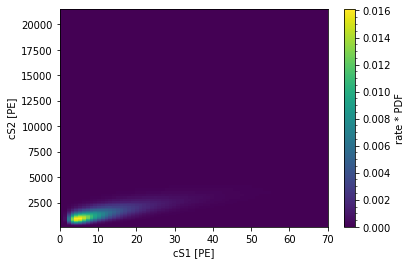

In [9]:
for dname, q in dsets.items():
    q['mh'] = mh = Histdd(bins=(
        np.linspace(0, 70, 71 + 1),
        np.geomspace(10**1.7 / (1 - 0.63),
                     10**3.9 / (1 - 0.63), 
                     70)
        #np.linspace(0, 5e3, 70),
    ))
    
    # Actually 40 gives pretty good results already, but let's do it right
    n_batches = 100 if dname == 'er' else 40
    trials_per_batch = int(1e5)
    
    for _ in tqdm(range(n_batches)):
        d = q['source'].simulate(trials_per_batch)
        annotate_cs(d)
        mh.add(d['cs1'], d['cs2'])
    
    # Convert to PDF
    mh /= mh.bin_volumes() * trials_per_batch * n_batches

    # Multiply by total expected event rate
    # (from the source, i.e. before correcting for efficiencies)
    mh *= q['source'].mu_before_efficiencies()
    q['mh'] = mh

    plt.yscale('log')
    mh.plot(cblabel='rate * PDF')
    plt.xlabel("cS1 [PE]")
    plt.ylabel("cS2 [PE]")
    plt.show()

  * Make sure none of the models are 'cut off' in cS1 / cS2, since cS1 and cS2 cut acceptances are not currently accounted for in our likelihood (unlike S1 or S2 cuts). This is not a limitation of flamedisx: the correction value is known for each event since the correction depends only on observables, so ultimately a cS1 cut is just a space-dependent S1 cut (which flamedisx fully supports).
  * The ROC curves will depend on the extent of the ER spectrum. If you include more high-energy ER events that can be discriminated anyway, the ER leakage in any likelihood will go down. The key figure of merit we are trying to derive here, the decrease in ER leakage at ~50 % NR acceptance when switching to the full likelihood, should be unaffected by this.

Discrimination ROC curve based on the histogram:

(0.0001, 1)

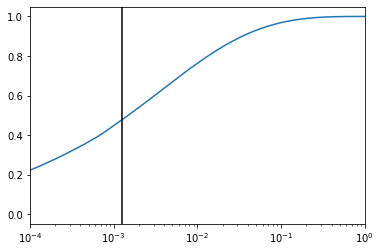

In [11]:
nr = dsets['nr']['mh'].histogram.ravel()
er = dsets['er']['mh'].histogram.ravel()

ins = np.argsort(er/(nr + 1e-9))
plt.figure()
plt.gcf().patch.set_facecolor('white')
plt.plot(np.cumsum(er[ins])/er.sum(),
         np.cumsum(nr[ins])/nr.sum())
plt.xscale('log')

plt.axvline(1/800, color='k')

plt.xlim(1e-4, 1)

## Compute flamedisx differential rates

In [13]:
for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](batch_size=100, max_sigma=6)

for dname, q in dsets.items():
    #ft_test = dict(x=0., y=0., z=-50,)
    q['data'] = d = q['source'].simulate(int(2e4))
    annotate_cs(d)
    
    # Ensure cs1 and cs2 are in range of the histogram
    # to avoid extrapolation in multihist's lookup.
    # NB: we are assuming both histograms have the same binning here!
    bes = q['mh'].bin_edges
    mask = (
        (bes[0][0] < d['cs1']) & (d['cs1'] < bes[0][-1]) &
        (bes[1][0] < d['cs2']) & (d['cs2'] < bes[1][-1])
    )
    print(f"{dname}: Throwing out {100 * (~mask).sum() / len(d):.2f}% of events")
    q['data'] = d = d[mask].copy()
    
    for _dn in dsets.keys():
        w = dsets[_dn]
        w['source'].set_data(d.copy())
        d['l_full_' + _dn] = w['source'].batched_differential_rate()
        d['l_mh_' + _dn] = w['mh'].lookup(d['cs1'], d['cs2'])
        
    for lt in ('mh', 'full'):
        d['lr_' + lt] = d['l_%s_er' % lt] / d['l_%s_nr' % lt]

er: Throwing out 0.0% of events


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [06:03<00:00,  2.47s/it]


nr: Throwing out 0.0392695857058708% of events


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [04:33<00:00,  2.68s/it]


# Results

In [28]:
# Load earlier results: 
# with open('discstudy_19oct_elife452_2.pkl', mode='rb') as f:
#     q = pickle.load(f)
#     for k, v in q.items():
#         dsets[k].update(**v)

## Compare differential rates

Compare differential rates. There will be an offset because (cS1, cS2) and (S1, S2) have different ranges/means -- so the rates are differential with respect to different coordinates.

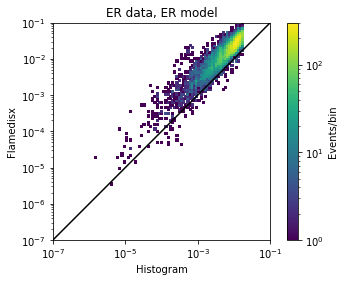

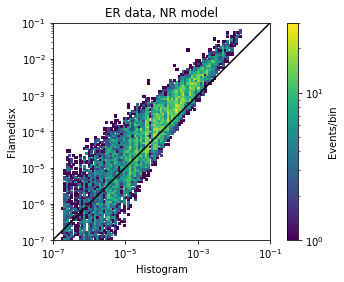

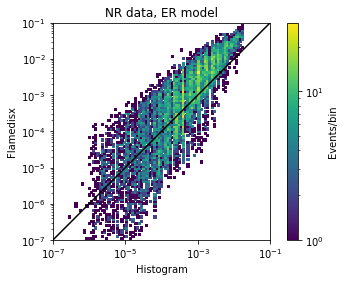

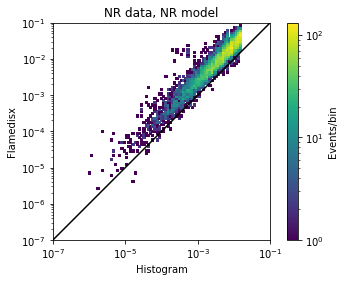

In [30]:
for dn in dsets:
    for lh_dn in dsets:
        q = dsets[dn]['data']
        plt.figure()
        plt.gcf().patch.set_facecolor('white')
        y, x = q['l_full_' + lh_dn], q['l_mh_' + lh_dn]

        Histdd(x, y,
               bins=(np.geomspace(1e-7, 1e-1, 100),
                     np.geomspace(1e-7, 1e-1, 100))).plot(
            log_scale=True, cblabel='Events/bin')

        plt.plot([1e-7, 1e-1], [1e-7, 1e-1], 'k-')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("Histogram")
        plt.ylabel("Flamedisx")
        plt.ylim(1e-7, 1e-1)
        plt.xlim(1e-7, 1e-1)
        plt.title(f"{dn.upper()} data, {lh_dn.upper()} model")
        plt.gca().set_aspect(1)
        plt.show()

In [31]:
# Zoom-in on the low-energy NR data
# d = dsets['nr']['data']
# dsets['er']['mh'].plot(log_scale=True, vmin=1e-6, vmax=1e-1, cmap=plt.cm.Blues, cblabel="Diffrate hist")
# plt.scatter(d['cs1'], d['cs2'], c=d['l_full_er'], s=0.1, 
#             vmax=1e-1, vmin=1e-6, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.Reds)
# plt.colorbar(label='Diffrate Flamedisx')
# plt.xlim(0, 10)
# plt.xlabel("cS1 [PE]")
# plt.ylim(0, 3e3)
# plt.ylabel("cS2 [PE]")

## Compare event-by-event discrimination

C:\Users\jelle\miniconda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jelle\miniconda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


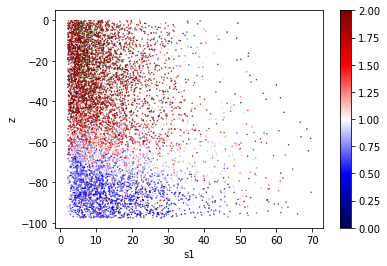

In [21]:
d_er = dsets['er']['data']
d_nr = dsets['nr']['data']

for d, alt, cmap in [#(d_er, d_nr, plt.cm.viridis),
                     (d_nr, d_er, plt.cm.magma)
                    ]:
    # For each event in d, find what fraction of the alt data is more NR-like than it
    # (under both likelihoods)
    f_above = {
        lt: np.searchsorted(np.sort(alt[f'lr_{lt}'].values), 
                            d[f'lr_{lt}'].values).astype(np.float) / len(alt)
        for lt in ('mh', 'full')}

    # Get ratio. 
    #   0 = mh sees the event as more NR-like than any of the alt data
    #   > 1: mh is worse at discriminating, < 1 mh is better at discriminating
    ratio = f_above['mh'] / f_above['full']
    mask = np.isfinite(ratio)
    
    xkey, ykey = 's1', 'z'
    
    plt.scatter(d[xkey][mask], d[ykey][mask], c=ratio[mask], #cmap=cmap,
                vmin=0, vmax=2, cmap=plt.cm.seismic,
                s=0.2,)
    plt.colorbar()
    plt.scatter(d[xkey][~mask], d[ykey][~mask], c='g',
                s=0.2, alpha=0.2)
    
    plt.xlabel(xkey)
    #plt.ylim(0, 700)
    plt.ylabel(ykey)
    plt.show()

For these NR events, red events have a more NR-like ER/NR likelihood ratio in flamedisx, and blue ones in the histogram likelihood.

In [32]:
# Saving data for later:
# dsets_data = dict()
# for dn in ['er', 'nr']:
#     dsets_data[dn] = dict()
#     for k, v in dsets[dn].items():
#         if k in ['source', 'source_class']:
#             continue
#         print(dn, k, type(v))
#         dsets_data[dn][k] = v
# import pickle
# with open('discstudy_19oct_elife452_3.pkl', mode='wb') as f:
#     pickle.dump(dsets_data, f)

Log likelihood ratio histograms for ER and NR data under both likelihoods below. Note many events are at +- 20 due to clip. 

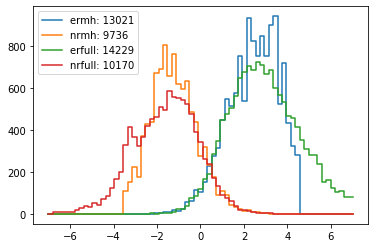

In [35]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, color in [['mh', 'b'], ['full', 'g']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        exp = 20
        hists[dname] = Hist1d(
            np.log10(q['data']['lr_' + lt].clip(10**-exp, 10**exp).values.astype('float')),
            bins=np.linspace(-7, 7, 70))
        hists[dname].plot(label=f"{dname}{lt}: {hists[dname].n}")
#plt.yscale('log')
plt.legend()
plt.show()

ROC Curves

mh: 0.00171 ER bg. at 50% NR acceptance
full: 0.0011 ER bg. at 50% NR acceptance


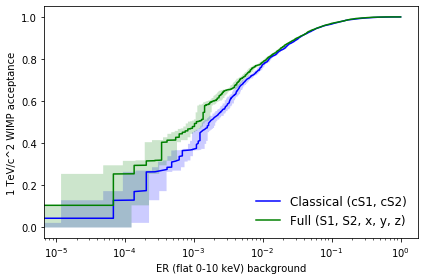

In [26]:
def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    
    # If something went wrong with a limit calculation, report the trivial limit
    lower[np.isnan(lower)] = 0
    upper[np.isnan(upper)] = 1
    return lower, upper

results = dict()

plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, color in [['mh', 'b'], ['full', 'g']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(1e-20, 1e20)),
                              bins=np.linspace(-21, 21, 10000))
        
        cis[dname] = binom_interval(
               np.cumsum(hists['er'].histogram),
               hists['er'].n, 
               conf_level=.68)
        
    x = np.cumsum(hists['er'].normalized_histogram)
    xlow, xhigh = cis['er'][0], cis['er'][1]
    y = np.cumsum(hists['nr'].normalized_histogram)
    
    results[lt] = dict(x=x, y=y, cis=cis, xlow=xlow, xhigh=xhigh, hists=hists)
    
    plt.plot(x, y,
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z)")[lt],
             color=color)
    
    print("%s: %0.3g ER bg. at 50%% NR acceptance" % (
        lt, x[np.argmin(np.abs(y - 0.5))]
    ))
    
    plt.fill_betweenx(
        y, cis['er'][0], cis['er'][1],
        color=color, alpha=0.2, linewidth=0, step='mid')
    
plt.legend(loc='lower right', frameon=False, fontsize=12)
    
plt.xscale('log')
plt.xlabel("ER (flat 0-10 keV) background")
plt.ylabel("1 TeV/c^2 WIMP acceptance")
#plt.xlim(1e-4, 1e-1)
#plt.xlim(0, 1)
#plt.ylim(0.95, 1)
plt.tight_layout()
#plt.savefig('ernr_disc_comp_varelife.png', bbox_inches="tight", dpi=200)
plt.show()


Background reduction plot

C:\Users\jelle\miniconda\envs\py36\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


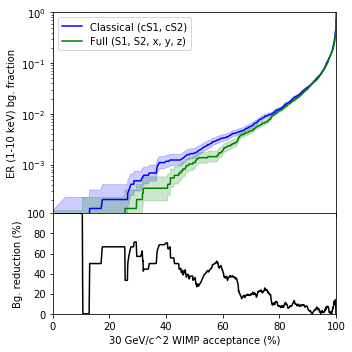

In [38]:
f, axes = plt.subplots(2, 1, 
                       figsize=(5, 5), 
                       gridspec_kw = {'height_ratios': [2, 1]},
                       sharex=True)
plt.gcf().patch.set_facecolor('white')

xscale = 100

for lt, color in [['mh', 'b'], ['full', 'g']]:
    q = results[lt]
    
    plt.sca(axes[0])
    plt.plot(q['y'] * xscale, q['x'],
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z)")[lt],
             color=color)
    plt.fill_between(
        q['y'] * xscale, q['xlow'], q['xhigh'],
        color=color, alpha=0.2)
    
def itp(x, xp, yp):
    return interpolate.interp1d(xp, yp, 
                                bounds_error=False, fill_value=(0,1))(x)
    
plt.sca(axes[1])
pts = np.linspace(0, 1, 1000)
r = {
    lt: {
        q: itp(pts, results[lt]['y'], results[lt]['x' + q])
          for q in ['', 'low', 'high']}
    for lt in results.keys()
}

plt.plot(pts * xscale, 
         100 * (r['mh']['']-r['full'][''])/r['mh'][''], c='k')

plt.ylabel("Bg. reduction (%)")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("%d GeV/c^2 WIMP acceptance (%%)" % dsets['nr']['source'].mw)

    
plt.sca(axes[0])
plt.yscale('log')
plt.ylim(1.1e-4, 1)
plt.legend(loc='upper left')
plt.ylabel("ER (1-10 keV) bg. fraction")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('ernr_disc_comp.png', bbox_inches="tight", dpi=200)